# A simple example, solved three ways

This notebook demonstrates a decomposition of a sine wave and a square wave using a very simple, convex SD model. We start by showing the default behavior, and then demonstrate the three methods that may be invoked using keyword arguements to solve a convex problem:

1. CVXPY
2. SD ADMM
3. Coordinate descent

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx

In [3]:
import sys
sys.path.append('..')
from osd import Problem
from osd.classes import MeanSquareSmall, SmoothSecondDifference, SparseFirstDiffConvex

In [4]:
rms = lambda x: np.sqrt(np.average(np.power(x, 2)))

## Data generation

In [5]:
np.random.seed(42)
t = np.linspace(0, 1000, 200)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
K, T = X_real.shape

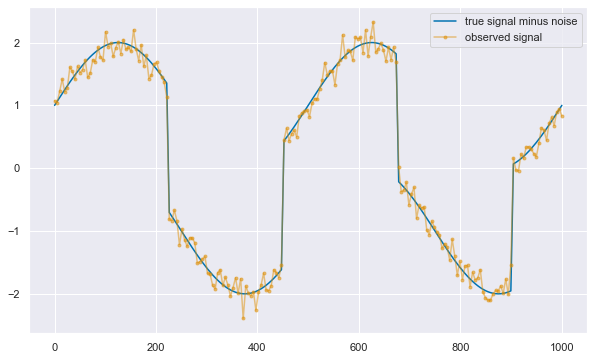

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(t, np.sum(X_real[1:], axis=0), label='true signal minus noise')
plt.plot(t, y, alpha=0.5, marker='.', label='observed signal')
plt.legend()
plt.show()

# Default settings

In [7]:
c1 = MeanSquareSmall(size=T)
c2 = SmoothSecondDifference(weight=1e3/T)
c3 = SparseFirstDiffConvex(weight=2e0/T, vmax=1, vmin=-1)
classes = [c1, c2, c3]
problem = Problem(y, classes)
problem.decompose()

Convex problem detected. Using BCD...
Starting BCD...
y shape: (200,)
X shape: (3, 200)

[====================] ...166 iterations, 2.87 sec -- obj_val: 9.50e-02, r: 1.02e-05, tol: 1.02e-05      



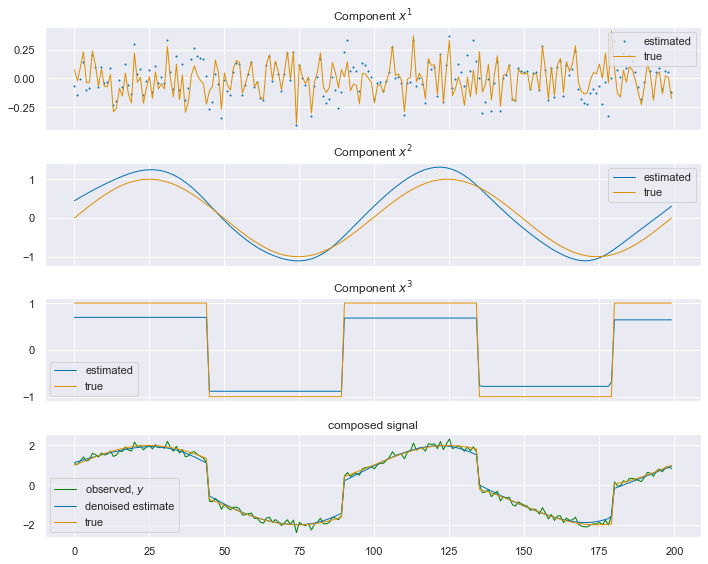

In [8]:
problem.plot_decomposition(X_real=X_real);

# CVXPY

In [9]:
c1 = MeanSquareSmall(size=T)
c2 = SmoothSecondDifference(weight=1e3/T)
c3 = SparseFirstDiffConvex(weight=2e0/T, vmax=1, vmin=-1)
classes = [c1, c2, c3]
problem1 = Problem(y, classes)

In [10]:
problem1.decompose(how='cvx')

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Feb 16 04:46:58 PM: Your problem has 600 variables, 3 constraints, and 3 parameters.
(CVXPY) Feb 16 04:46:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 16 04:46:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 16 04:46:58 PM: Compiling problem (target solver=OSQP).
(CVXPY) Feb 16 04:46:58 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Feb 16 04:46:58 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 16 04:46:58 PM: Applying reduction Qp2SymbolicQp

In [11]:
opt_obj_val = problem1.objective_value
opt_obj_val

0.09502286307165887

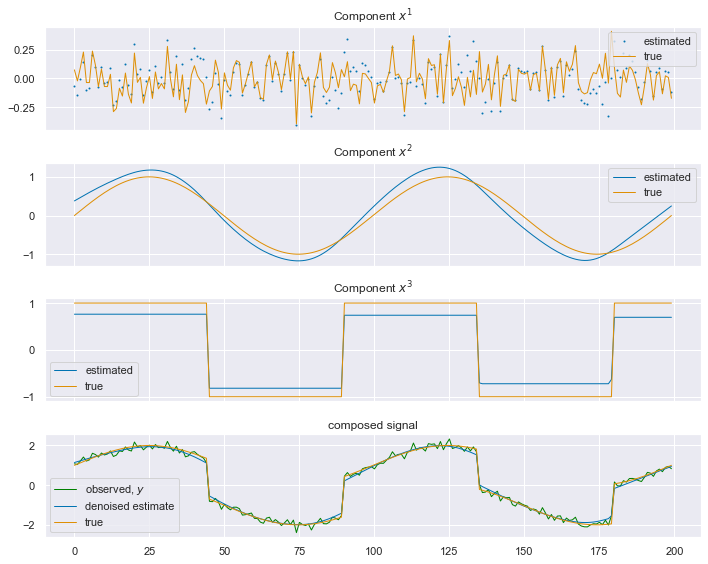

In [12]:
problem1.plot_decomposition(X_real=X_real);

# SD ADMM

In [13]:
problem2 = Problem(y, classes)
problem2.decompose(how='admm', verbose=True)
problem2.objective_value

[====================] ...155 iterations, 2.89 sec -- obj_val: 9.50e-02, r: 1.02e-05, tol: 1.02e-05      



0.09502381299768056

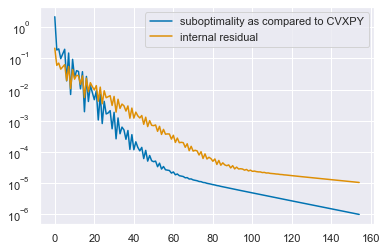

In [14]:
plt.figure()
plt.plot(problem2.admm_result['obj_vals'] - opt_obj_val, label='suboptimality as compared to CVXPY')
plt.plot(problem2.admm_result['optimality_residual'], label='internal residual')
plt.yscale('log')
plt.legend()
plt.show()

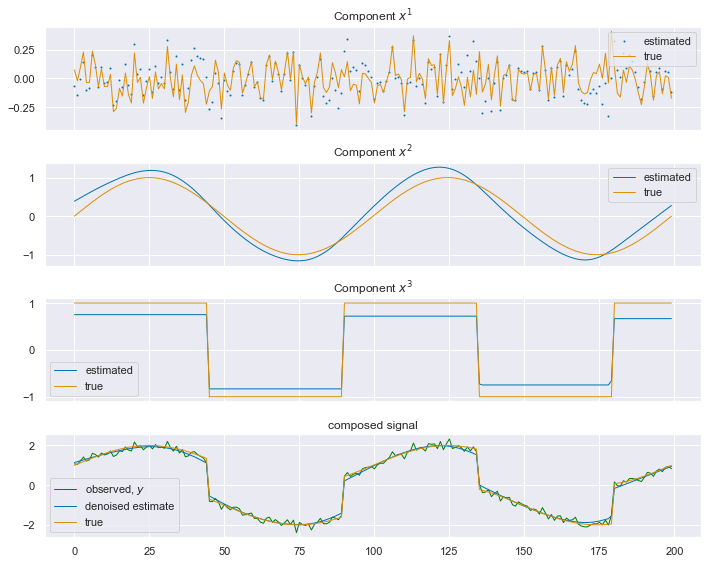

In [15]:
problem2.plot_decomposition(X_real=X_real);

# Coordinate Descent

In [16]:
problem3 = Problem(y, classes)
problem3.decompose(how='bcd')
problem3.objective_value

Starting BCD...
y shape: (200,)
X shape: (3, 200)

[====================] ...166 iterations, 2.91 sec -- obj_val: 9.50e-02, r: 1.02e-05, tol: 1.02e-05      



0.09502336446807377

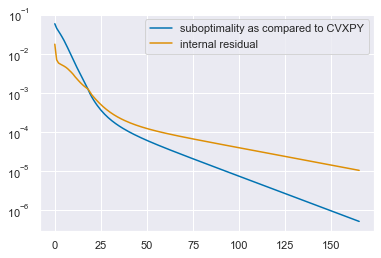

In [17]:
plt.figure()
plt.plot(problem3.bcd_result['obj_vals'] - opt_obj_val, label='suboptimality as compared to CVXPY')
plt.plot(problem3.bcd_result['optimality_residual'], label='internal residual')
plt.yscale('log')
plt.legend()
plt.show()

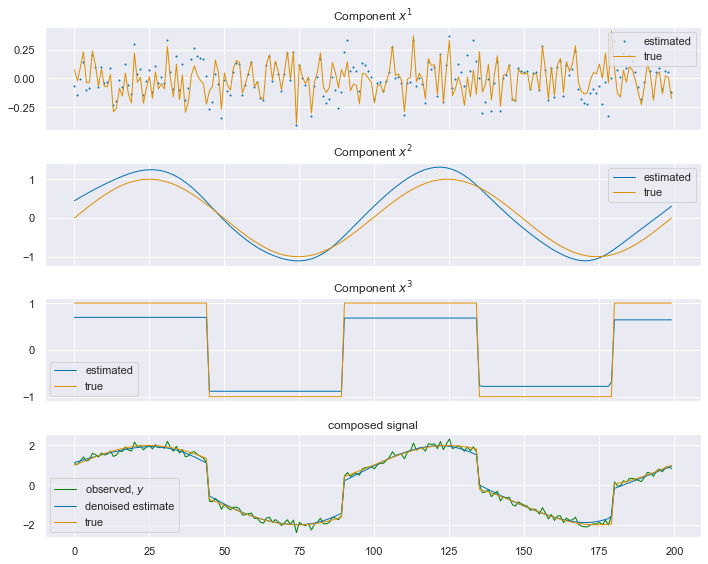

In [18]:
problem3.plot_decomposition(X_real=X_real);

# Comparisons between ADMM and BCD

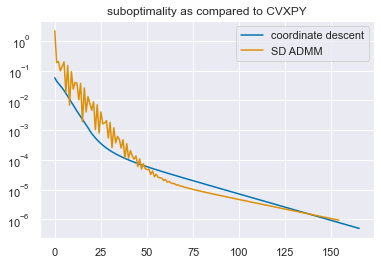

In [19]:
plt.figure()
plt.plot(problem3.bcd_result['obj_vals'] - opt_obj_val, label='coordinate descent')
plt.plot(problem2.admm_result['obj_vals'] - opt_obj_val, label='SD ADMM')
plt.title('suboptimality as compared to CVXPY')
plt.yscale('log')
plt.legend()
plt.show()

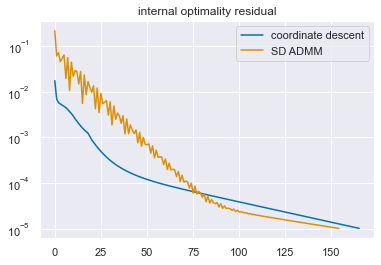

In [20]:
plt.figure()
plt.plot(problem3.bcd_result['optimality_residual'], label='coordinate descent')
plt.plot(problem2.admm_result['optimality_residual'], label='SD ADMM')
plt.yscale('log')
plt.title('internal optimality residual')
plt.legend()
plt.show()